Download pretrained model from https://huggingface.co/timm/vgg19.tv_in1k

In [4]:
from urllib.request import urlopen
from PIL import Image
import timm
import torch
import json
import urllib.request
from torchvision import models, transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

img = Image.open(urlopen(
    'https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/beignets-task-guide.png'
))

model_path = "../vgg16.tv_in1k/pytorch_model.bin"#"../vgg19.tv_in1k/pytorch_model.bin"
state_dict = torch.load(model_path, map_location=torch.device('cpu'))#timm.create_model('vgg19', pretrained=True)

model = timm.create_model('vgg16', pretrained=False)
model.load_state_dict(state_dict)

model.to(device)

model = model.eval()

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)

output = model(transforms(img).unsqueeze(0).to(device))  # unsqueeze single image into batch of 1

top5_probabilities, top5_class_indices = torch.topk(output.softmax(dim=1) * 100, k=5)
print(top5_probabilities)


# Load the ImageNet class index
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
class_index = json.loads(urllib.request.urlopen(url).read().decode())

# Get the top 5 class indices and probabilities
top5_class_indices = top5_class_indices.squeeze().tolist()
top5_probabilities = top5_probabilities.squeeze().tolist()

# Print the top 5 class labels and probabilities
for i in range(5):
    class_index_str = class_index[str(top5_class_indices[i])]
    class_label = class_index_str[1]
    print(f"{class_label}: {top5_probabilities[i]:.2f}%")

KeyboardInterrupt: 

In [1]:
from ImageFolderDataset import ImageFolderDataset
from ImageFolderDataset import loadAndPrepareData, countSamplesPerClass
from TumorClassifier import TumorClassifier
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import timm

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 6, 5)  # 3 input channels, 6 output channels, 5x5 kernel
        self.pool = nn.MaxPool2d(2, 2)  # 2x2 max pooling
        self.conv2 = nn.Conv2d(6, 16, 5)  # 6 input channels, 16 output channels, 5x5 kernel
        # the number of input features to the first fully connected layer depends on the size of your input image.
        # Given the pooling and convolutional layers above and an input image size of 512x512, it would be 16*125*125
        self.fc1 = nn.Linear(16 * 125 * 125, 120)  # input features, output features
        self.fc2 = nn.Linear(120, 84)  # input features, output features
        self.fc3 = nn.Linear(84, num_classes)  # input features, output features

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # apply conv1, ReLU, then max pooling
        x = self.pool(F.relu(self.conv2(x)))  # apply conv2, ReLU, then max pooling
        x = x.view(-1, 16 * 125 * 125)  # flatten the tensor
        x = F.relu(self.fc1(x))  # apply fc1 and ReLU
        x = F.relu(self.fc2(x))  # apply fc2 and ReLU
        x = self.fc3(x)  # apply fc3
        x = F.softmax(x, dim=1)  # apply softmax to output
        return x
    

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# -------- DATA -------- #

root_dir = '../resized/512x512/'
train_loader, val_loader, dataset = loadAndPrepareData(root_dir, batch_size=4, n_classes=127)

print("==== Training Dataset ====")
print(f"Number of samples: {len(train_loader.dataset)}")
#print(f"Samples per class: {countSamplesPerClass(train_loader)}")

print("==== Validation Dataset ====")
print(f"Number of samples: {len(val_loader.dataset)}")
#print(f"Samples per class: {countSamplesPerClass(val_loader)}")

print(f"\nNumber of classes: {len(set(dataset.labels))}")
print(f"Classes: {set(dataset.classes)}")

print(dataset.classes)

img, labels = next(iter(train_loader))
print(img.shape)
print(labels)

Counter({56: 474, 104: 173, 85: 104, 110: 99, 6: 91, 50: 88, 59: 88, 0: 85, 93: 85, 13: 83, 117: 81, 30: 70, 125: 68, 32: 59, 57: 59, 47: 57, 3: 50, 1: 47, 2: 47, 27: 47, 87: 47, 5: 46, 40: 46, 118: 41, 71: 38, 55: 34, 61: 34, 68: 32, 78: 32, 9: 31, 60: 30, 21: 28, 113: 28, 15: 25, 35: 25, 105: 24, 121: 24, 88: 23, 90: 23, 18: 21, 24: 21, 34: 21, 54: 21, 111: 21, 16: 20, 53: 20, 31: 19, 14: 17, 102: 17, 91: 16, 75: 15, 120: 14, 25: 13, 73: 13, 97: 13, 20: 12, 29: 11, 101: 11, 116: 11, 92: 10, 80: 9, 95: 9, 96: 8, 11: 7, 23: 7, 63: 7, 81: 7, 41: 6, 52: 6, 77: 6, 106: 6, 108: 6, 4: 5, 64: 5, 76: 5, 83: 5, 89: 5, 107: 5, 114: 5, 12: 4, 17: 4, 19: 4, 44: 4, 70: 4, 86: 4, 8: 3, 39: 3, 48: 3, 62: 3, 79: 3, 82: 3, 100: 3, 109: 3, 115: 3, 10: 2, 46: 2, 51: 2, 66: 2, 74: 2, 84: 2, 98: 2, 99: 2, 7: 1, 22: 1, 26: 1, 28: 1, 33: 1, 36: 1, 37: 1, 38: 1, 42: 1, 43: 1, 45: 1, 49: 1, 58: 1, 65: 1, 67: 1, 69: 1, 72: 1, 94: 1, 103: 1, 112: 1, 119: 1, 122: 1, 123: 1, 124: 1, 126: 1})
==== Training Dataset

In [2]:
# -------- MODEL -------- #

model_path = "../vgg16.tv_in1k/pytorch_model.bin"
state_dict = torch.load(model_path, map_location=torch.device('cpu'))#timm.create_model('vgg19', pretrained=True)

model = timm.create_model('vgg16', pretrained=False)
model.load_state_dict(state_dict)

output_dim = len(set(dataset.labels))


#model = SimpleCNN(output_dim)

# Replace the last fully connected layer to match the number of classes in the new data set
num_ftrs = model.head.fc.in_features
#model.head.fc = nn.Linear(num_ftrs, output_dim)

# Add dropout
model.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, output_dim)
)

model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


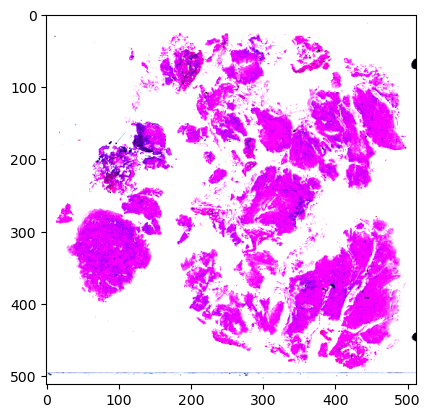

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


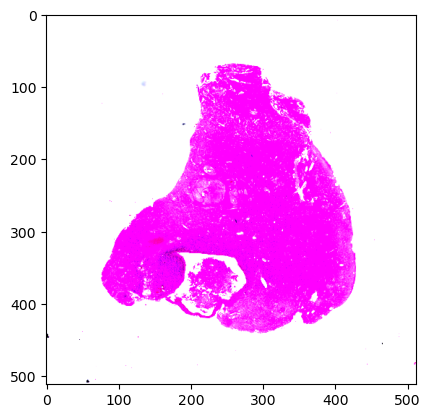

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


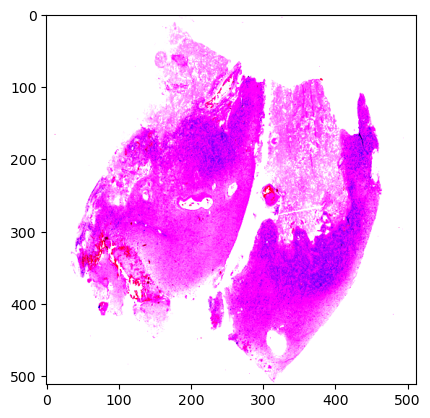

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


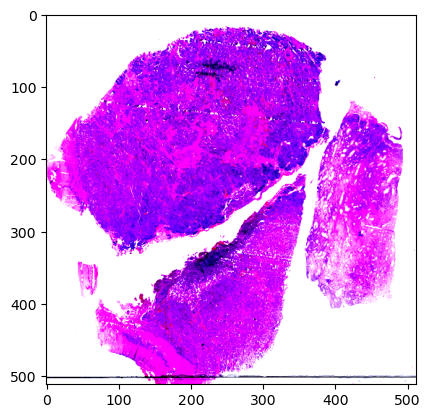

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


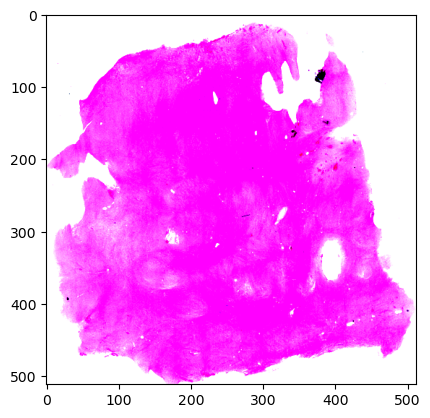

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


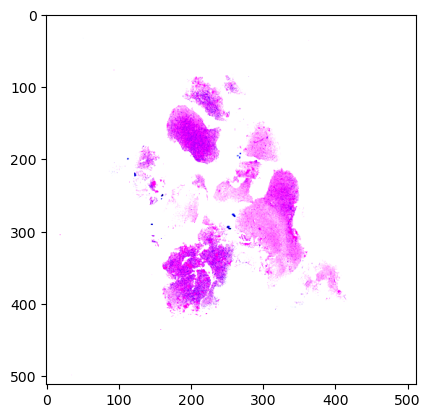

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


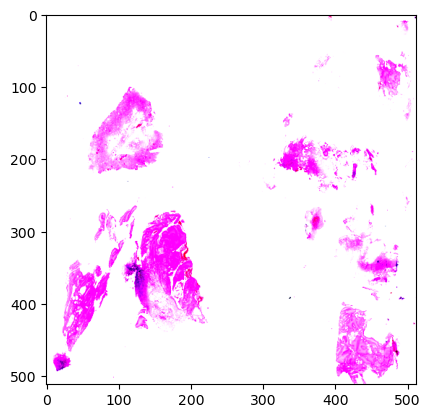

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


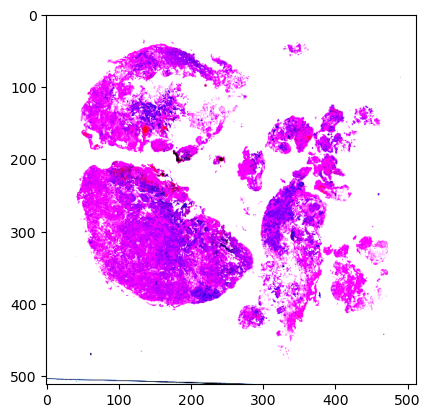

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


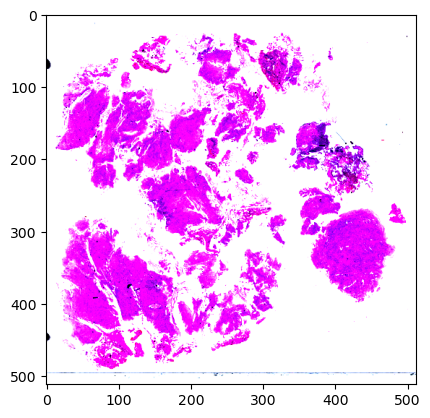

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


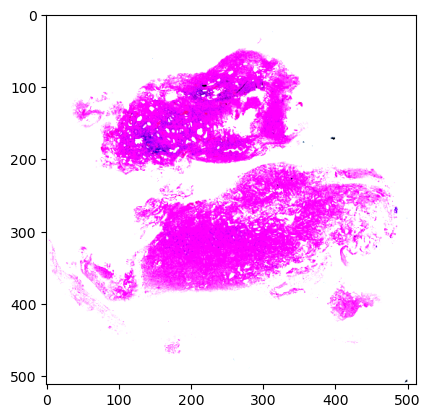

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


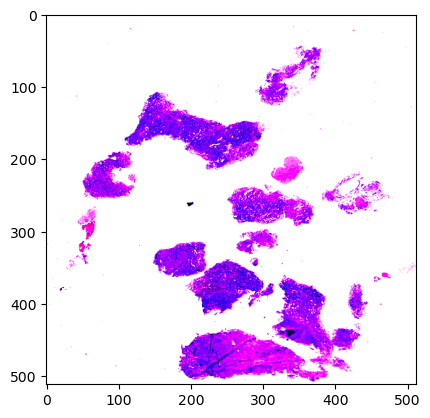

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


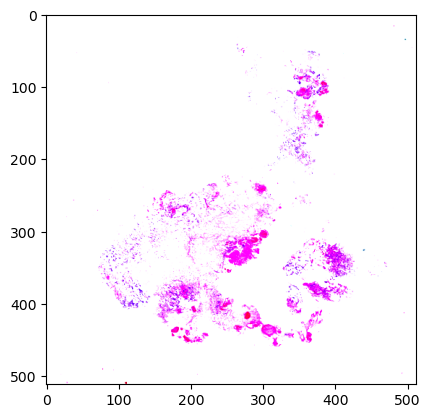

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


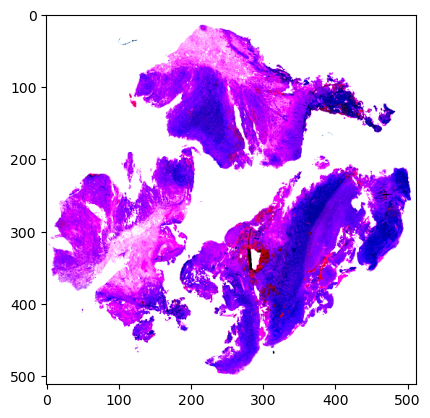

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


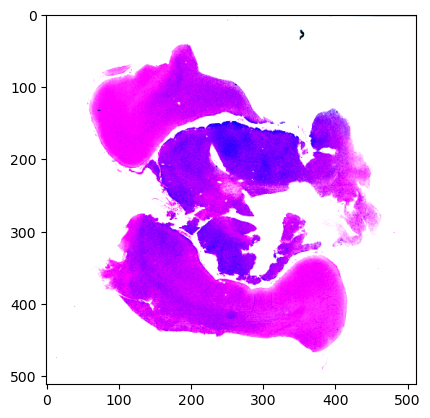

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


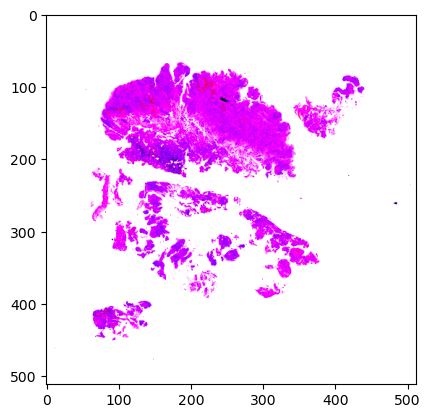

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


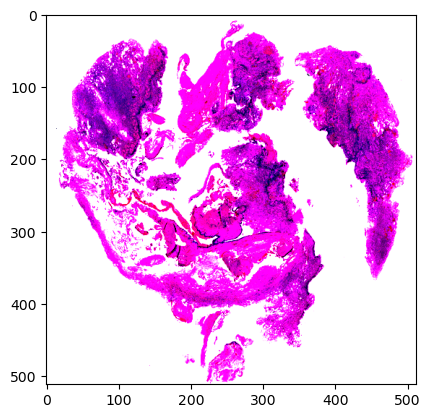

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


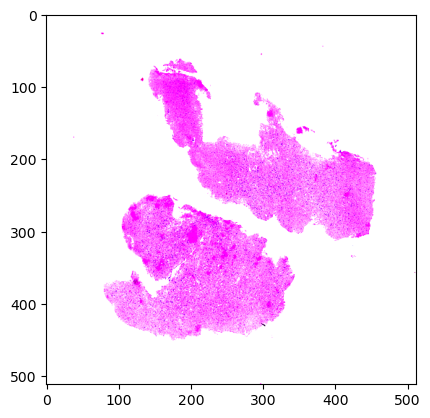

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


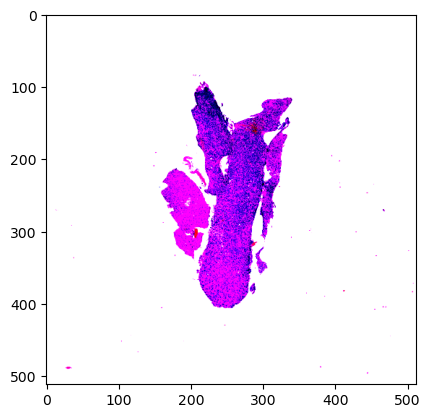

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


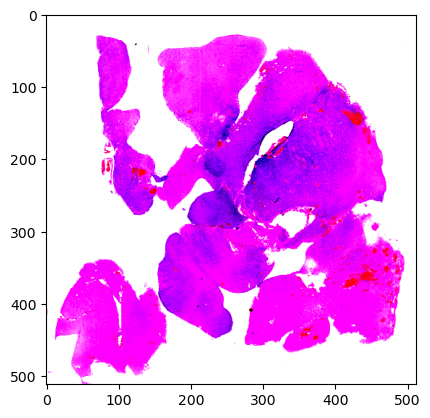

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


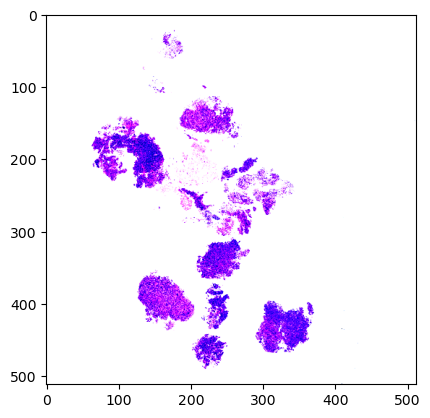

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


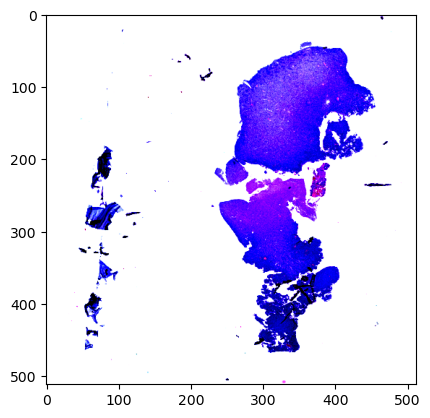

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


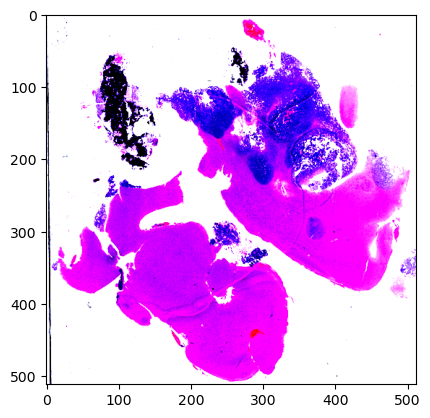

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


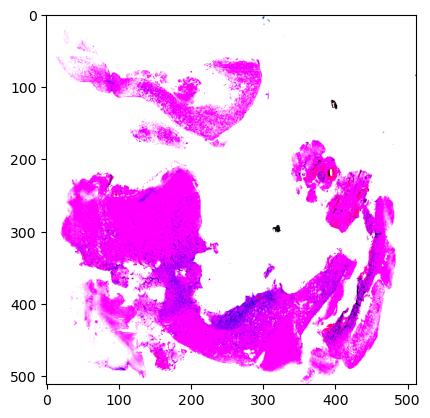

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


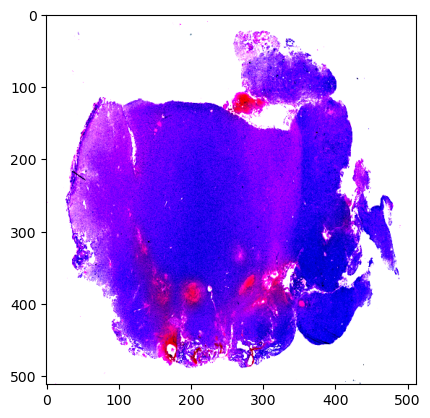

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


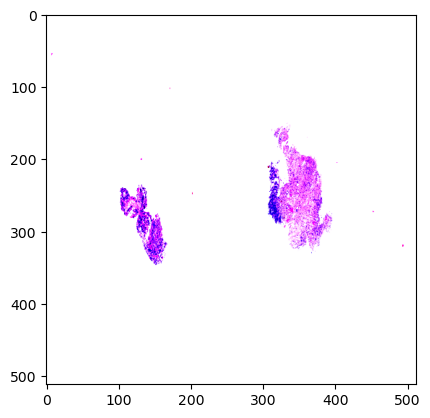

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


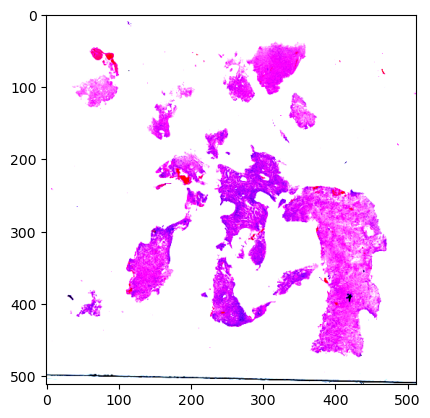

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


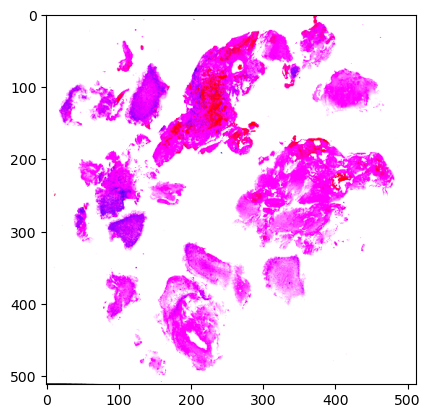

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


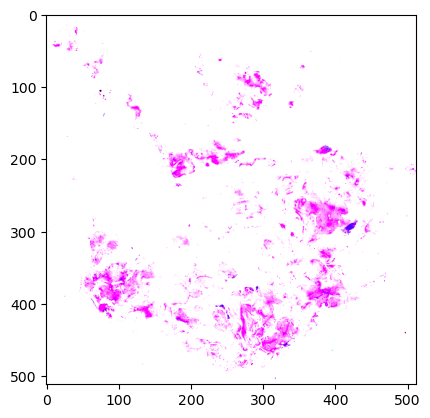

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


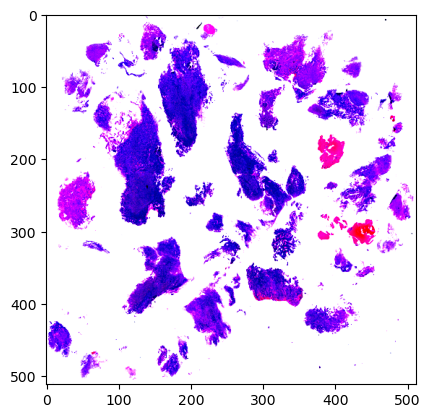

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


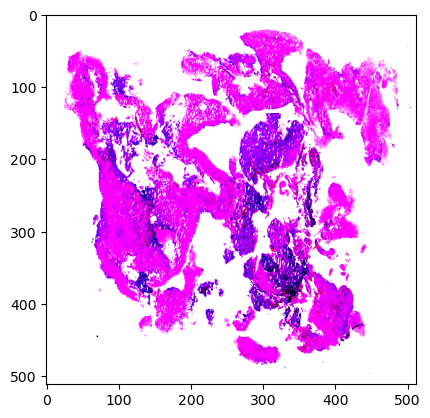

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


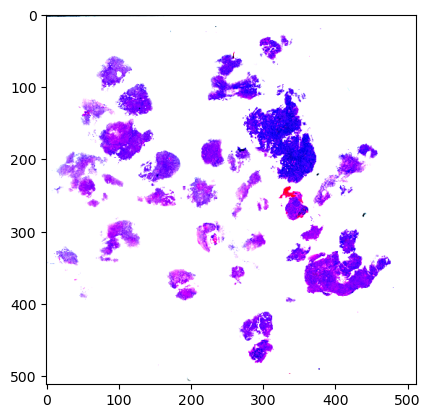

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


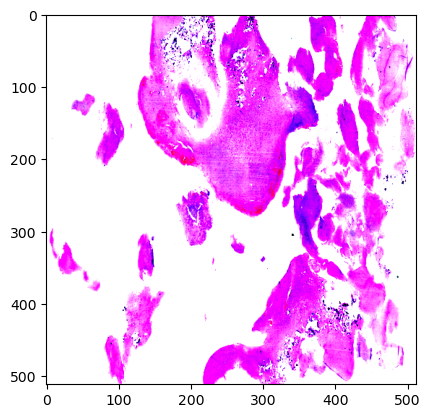

In [ ]:
from matplotlib import pyplot as plt

for _img in img:
    plt.figure()
    plt.imshow(_img.permute(1, 2, 0))
    plt.show()

In [3]:
from matplotlib import pyplot as plt
import math

train_losses = []
val_losses = []

def save_model(model, filepath):
    torch.save(model.state_dict(), filepath)

def load_model(model_class, filepath):
    model = model_class()  # Initialize model
    model.load_state_dict(torch.load(filepath))
    return model

def train():
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    # Initialize the learning rate scheduler
    #scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, verbose=True)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=1.0/math.e)

    # Train the model
    num_epochs = 1000
    print('Starting training...')
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = model(inputs.to(device))
            loss = criterion(outputs, labels.to(device))
            loss.backward()
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
            if i % 10 == 9:
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))
                running_loss = 0.0
            
        if epoch % 50 == 0:
            save_model(model, f"./models/model_{epoch}.pt")

        # Calculate the training loss for the current epoch
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Evaluate the model on the validation set
        val_loss = evaluate(model, val_loader, criterion)
        val_losses.append(val_loss)

        print('Epoch %d: Training Loss: %.3f, Validation Loss: %.3f' % (epoch + 1, train_loss, val_loss))

        # Step the learning rate scheduler
        scheduler.step()#val_loss)

    # Plot the training and validation losses
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    total_samples = 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs.to(device))
            loss = criterion(outputs, labels.to(device))
            total_loss += loss.item() * labels.size(0)
            total_samples += labels.size(0)
    
    model.train()
    return total_loss / total_samples

# move to device
model = model.to(device)
train()
model = model.to('cpu')

Starting training...
[1,    10] loss: 6.478
[1,    20] loss: 5.942
[1,    30] loss: 5.617
[1,    40] loss: 5.595
[1,    50] loss: 5.391
[1,    60] loss: 5.092
[1,    70] loss: 5.325
[1,    80] loss: 5.544
[1,    90] loss: 5.233
[1,   100] loss: 5.253
[1,   110] loss: 5.177
[1,   120] loss: 5.222
[1,   130] loss: 5.176
[1,   140] loss: 5.195
[1,   150] loss: 5.182
[1,   160] loss: 5.058
[1,   170] loss: 5.217
[1,   180] loss: 4.912
[1,   190] loss: 4.953
[1,   200] loss: 4.958
[1,   210] loss: 4.956
[1,   220] loss: 5.099
[1,   230] loss: 5.034
[1,   240] loss: 5.059
[1,   250] loss: 4.912
[1,   260] loss: 4.954
[1,   270] loss: 5.052
[1,   280] loss: 4.922
[1,   290] loss: 4.879
[1,   300] loss: 4.945
[1,   310] loss: 4.944
[1,   320] loss: 4.898
[1,   330] loss: 4.816
[1,   340] loss: 4.869
[1,   350] loss: 4.605
[1,   360] loss: 4.953
[1,   370] loss: 4.826
[1,   380] loss: 4.676
[1,   390] loss: 4.517
[1,   400] loss: 4.910
[1,   410] loss: 4.701
[1,   420] loss: 4.856
[1,   430] lo

KeyboardInterrupt: 

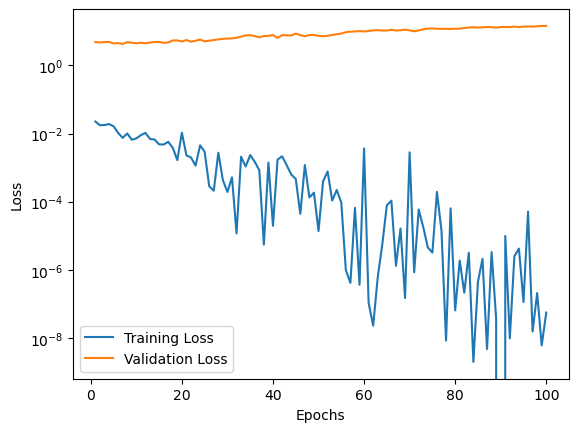

In [8]:
plt.plot(range(1, 100 + 1), train_losses[:100], label='Training Loss')
plt.plot(range(1, 100 + 1), val_losses[:100], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.show()

# save train and validation losses
import numpy as np	
np.save('train_losses.npy', train_losses)
np.save('val_losses.npy', val_losses)

In [4]:
model = model.to('cpu')
torch.cuda.empty_cache()


In [13]:
torch.cuda.empty_cache()
del model

In [ ]:
print(os.listdir(root_dir)[56])

print(len(train_loader.dataset))

Glioblastoma, IDH-wildtype
752


In [4]:
def save_model(model, filepath):
    torch.save(model.state_dict(), filepath)

def load_model(model_class, filepath):
    model = model_class()  # Initialize model
    model.load_state_dict(torch.load(filepath))
    return model

save_model(model, 'vgg16_finetuned_10_classes.pt')

In [ ]:
model2 = load_model(TumorClassifier, 'finetuned.pt')


TypeError: __init__() missing 1 required positional argument: 'output_dim'

In [ ]:
import matplotlib.pyplot as plt

model = model.to('cpu')

def plot_images(image, label, pred):
    plt.figure(figsize=(4, 4))
    image = image.permute(1, 2, 0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    image = image * std + mean
    plt.imshow(image.numpy())
    plt.title(f'Label: {label}, Prediction: {pred}')
    plt.axis('off')
    plt.show()

def visualize_predictions(model, loader):
    model.eval()
    correct_imgs = []
    correct_labels = []
    correct_preds = []
    
    incorrect_imgs = []
    incorrect_labels = []
    incorrect_preds = []
    
    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images)
            _, preds = torch.max(outputs, dim=1)
            print(outputs)
            for i in range(len(labels)):
                if preds[i] == labels[i] and len(correct_imgs) < 3:
                    correct_imgs.append(images[i])
                    correct_labels.append(labels[i])
                    correct_preds.append(preds[i])
                elif preds[i] != labels[i] and len(incorrect_imgs) < 3:
                    incorrect_imgs.append(images[i])
                    incorrect_labels.append(labels[i])
                    incorrect_preds.append(preds[i])

            if len(correct_imgs) >= 3 and len(incorrect_imgs) >= 3:
                break

    print("Correct Predictions:")
    for i in range(3):
        plot_images(correct_imgs[i], correct_labels[i], correct_preds[i])

    print("Incorrect Predictions:")
    for i in range(3):
        plot_images(incorrect_imgs[i], incorrect_labels[i], incorrect_preds[i])

# Assume `model` is your trained model and `loader` is your validation dataloader
visualize_predictions(model, train_loader)


tensor([[  5.2835,   7.8686,  -9.2059,  -7.2759, -12.1569],
        [ -3.0661,  -4.3268, -12.9135,  -8.4477,  11.9754],
        [  6.7607,   3.5779, -14.0150,  -4.2293,  -9.8046],
        [ -5.7020,  -0.6958,  -6.0412,  -7.2186,   7.7188],
        [ -2.2659,  10.0133, -14.5323,   4.9789, -20.7183],
        [-12.3566,  -1.2608,  13.4165,   4.6803, -18.9953],
        [-20.3034,   7.0435, -14.6653,  21.2379, -28.0528],
        [-11.1771,  -0.4625,   8.9477,   2.3056,  -9.0008]])
tensor([[-3.2725e+00, -6.9170e-01, -2.5542e+01, -1.4503e+01,  1.7440e+01],
        [-8.2861e-01, -2.1711e+00,  7.7930e+00, -4.9893e+00, -1.3174e+01],
        [-4.9483e+01, -1.4632e+01,  8.3521e+01, -3.3185e+00, -8.9230e+01],
        [-3.4293e+01, -5.7300e+00,  6.2362e+01,  5.4041e-01, -7.5406e+01],
        [ 9.8239e+00, -1.1526e+00, -1.3913e+01, -8.8313e+00, -8.0410e+00],
        [ 4.8340e-01,  7.7605e+00, -1.1052e+01,  1.3475e+00, -1.4470e+01],
        [-1.6180e+01, -1.5767e-03,  1.3522e+01,  2.3964e+00, -1.1930e

KeyboardInterrupt: 